In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.oso_db import execute_query

In [2]:
grants_df = pd.read_json("data/2023-10-01_op_tracked_grants.json")
grants_df['collection'] = grants_df['tags'].apply(lambda x: 'op-rpgf2' if 'RPGF2' in x else 'op-govgrants')
get_stats = lambda x: x.groupby('collection')['amount'].agg(['count', 'sum']).T.to_dict()
grant_stats = {
    "all_grants": get_stats(grants_df),
    "oss_grants": get_stats(grants_df[grants_df['slug'] != ""])
}
grant_stats

{'all_grants': {'op-govgrants': {'count': 240, 'sum': 68792330},
  'op-rpgf2': {'count': 195, 'sum': 10000007}},
 'oss_grants': {'op-govgrants': {'count': 194, 'sum': 65548249},
  'op-rpgf2': {'count': 140, 'sum': 8223408}}}

In [3]:
rpgf2 = grants_df[grants_df['collection'] == 'op-rpgf2']
rpgf2.at[383,'slug'] = 'goerli'
slugs = list(rpgf2['slug'].unique())

In [4]:
slugs_list = "','".join(slugs)

query = f"""
    SELECT p.slug, MAX(e.amount) AS stars
    FROM event e
    LEFT JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN project p ON paa."projectId" = p."id"
    WHERE p.slug IN ('{slugs_list}') AND e."typeId" = 22
    GROUP BY p.slug, e."fromId";
"""

results = execute_query(query, col_names=True)

In [5]:
df = pd.DataFrame(results[1:], columns=results[0])
df.set_index('slug', drop=True, inplace=True)
df = rpgf2.set_index('slug').join(df).dropna()
df.head()

,project,link,amount,tags,collection,stars
slug,,,,,,
0x-splits,0xSplits,https://app.optimism.io/retropgf-discovery/0x9...,52154,[RPGF2],op-rpgf2,29.0
0xparc,0xPARC,https://app.optimism.io/retropgf-discovery/0x5...,206054,[RPGF2],op-rpgf2,62.0
across,Across Protocol,https://app.optimism.io/retropgf-discovery/0x3...,15039,[RPGF2],op-rpgf2,23.0
akula-bft,Akula,https://app.optimism.io/retropgf-discovery/0x9...,39664,[RPGF2],op-rpgf2,130.0
ankr-network,Ankr,https://app.optimism.io/retropgf-discovery/0x5...,8603,[RPGF2],op-rpgf2,42.0


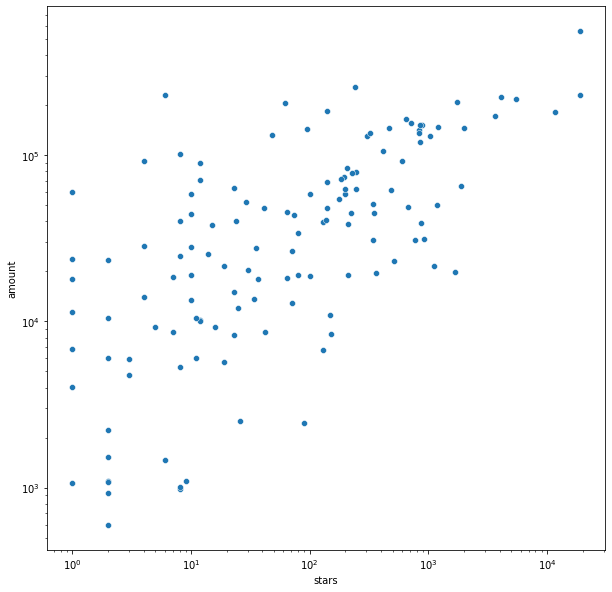

In [6]:
fix, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(data=df, x='stars', y='amount')

ax.set_xscale('log')
ax.set_yscale('log')